In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import nibabel
import skimage

import simple_mri as sm
from simple_mri import load_mri, change_of_coordinates_map
from gmri2fem.utils import largest_island
from gmri2fem.segmentation_refinement import resample_segmentation
from gmri2fem.visualization import slice_volume


In [2]:
sessions = [f"ses-{idx:02d}" for idx in range(1, 6)]

nICE_paths = [
    f"../mri_dataset/derivatives/sub-01/ses-{idx:02d}/sub-01_ses-{idx:02d}_acq-looklocker_T1map_nICE.nii.gz"
    for idx in range(1, 6)
]
nICE_mris = [
    load_mri(p, dtype=np.single) for p in nICE_paths
]
custom_paths = [
    f"../mri_dataset/derivatives/sub-01/ses-{idx:02d}/sub-01_ses-{idx:02d}_acq-looklocker_T1map.nii.gz"
    for idx in range(1, 6)
]
custom_mris = [
    load_mri(p, dtype=np.single) for p in custom_paths
]

mask_path = "../mri_processed_data/sub-01/segmentations/sub-01_seg-intracranial_binary.nii.gz"
mask_mri = sm.load_mri(
    mask_path,
    dtype=bool
)

In [3]:
masks = []
T_path = [
    f"../mri_processed_data/sub-01/transforms/sub-01_{ses}_acq-looklocker.mat"
    for ses in sessions
]
tmppaths = [f"tmp-ll-nice-ses-{idx:02d}.nii.gz" for idx in range(1, 6)]

for idx in range(5):
    if not Path(tmppaths[idx]).exists():
        cmd = f"greedy -d 3 -rf {nICE_paths[idx]} -ri NN -rm {mask_path} {tmppaths[idx]} -r {T_path[idx]},-1"
        !{cmd}
    newmask = sm.load_mri(tmppaths[idx], dtype=bool)
    
    # nICE data clipped above, remove these voxels from evaluation
    nice_filter = (nICE_mris[idx].data != 0) * (nICE_mris[idx].data != np.nanmax(nICE_mris[idx].data))
    masks.append(newmask.data * nice_filter)

In [4]:
e = np.nan * np.zeros((5, *custom_mris[0].shape))
for idx, mask in enumerate(masks):
    T1_i = custom_mris[idx].data
    nice_i = nICE_mris[idx].data
    e[idx][mask] = (T1_i[mask] - nice_i[mask]) / (0.5 *(T1_i[mask] + nice_i[mask]))
errors = [e_i[mask_i] for (e_i, mask_i) in zip(e, masks)]

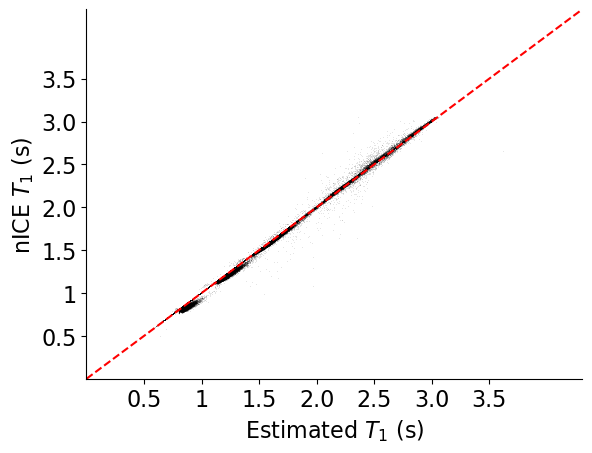

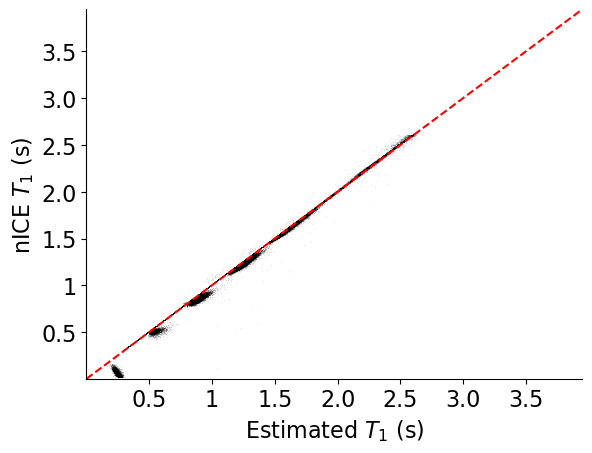

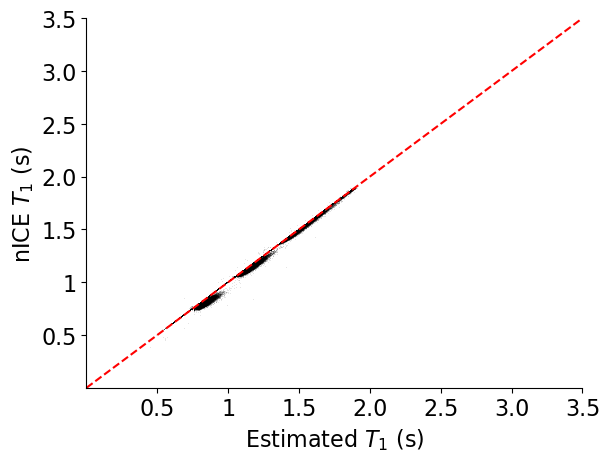

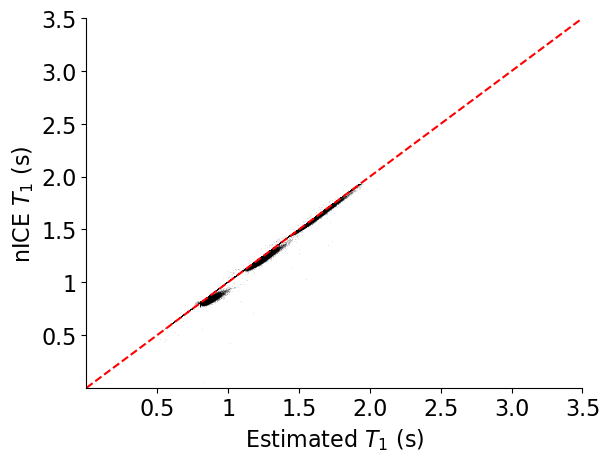

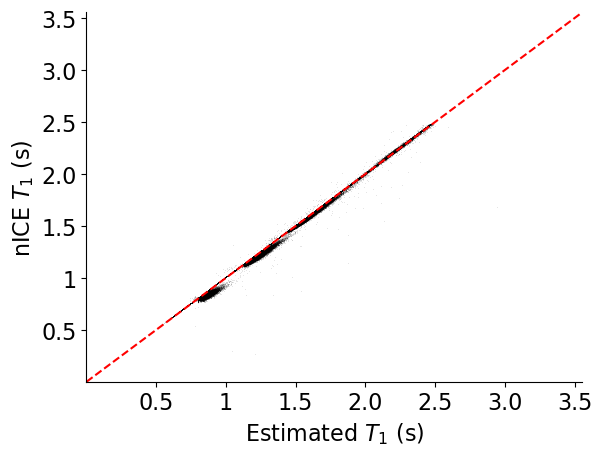

In [5]:
custom, nICE = [x.data for x in custom_mris], [y.data for y in nICE_mris]
ticks_seconds = (0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5)
for idx, (T1_i, nice_i, mask) in enumerate(zip(custom, nICE, masks)):
    plt.figure()
    plt.plot(T1_i[mask], nice_i[mask], marker=",", linestyle="", color="k", alpha=0.1, rasterized=True)
    plt.plot([0, 10000], [0, 10000], ls="--", color="r")
    max_val = max(np.nanquantile(T1_i, 0.99), np.nanquantile(nice_i, 0.99))
    plt.xlim(0, 1.2 * max_val)
    plt.ylim(0, 1.2 * max_val)   
    plt.xlabel("Estimated $T_1$ (s)")
    plt.ylabel("nICE $T_1$ (s)")
    plt.gca().spines[["top", "right"]].set_visible(False)
    plt.yticks([1000*xi for xi in ticks_seconds], ticks_seconds)
    plt.xticks([1000*xi for xi in ticks_seconds], ticks_seconds)
    if idx == 0:
        plt.savefig("../figures/LL-nICE-scatter.pdf", bbox_inches="tight")
plt.show()

## Error Distribution Plots

### Absolute RPD eCDF

In [6]:
import seaborn as sns
import pandas as pd

idx = 1
ei = errors[0]
frames = [
    pd.DataFrame(dict(Session=[f"ses-{idx:02d}"] * len(ei), RPD=np.abs(ei)*100))
    for idx, ei in enumerate(errors, start=1)
]
frame = pd.concat(frames)

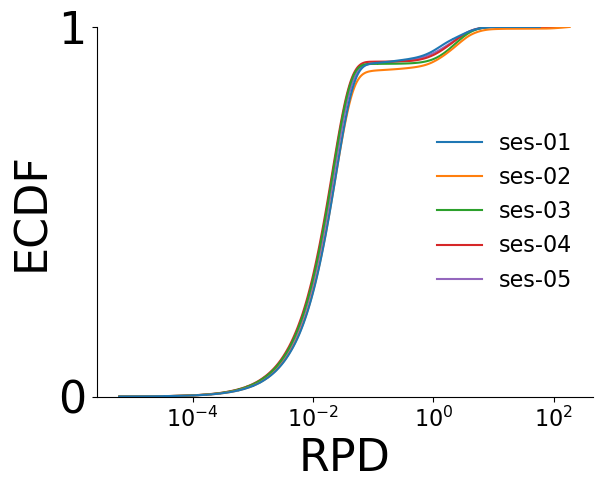

In [7]:
sns.ecdfplot(frame, x="RPD", hue="Session", log_scale=True)
ax = plt.gca()
legend = ax.get_legend()
legend.set_title("")
legend.set_frame_on(False)
legend.set_loc("center right")
plt.yticks([0,1], fontsize=16*2)
plt.ylabel("ECDF", fontsize=16 * 2)
plt.xlabel(r'RPD', fontsize=16 * 2)
plt.savefig("../figures/LL-nICE-ecdf.pdf", bbox_inches="tight")
plt.show()

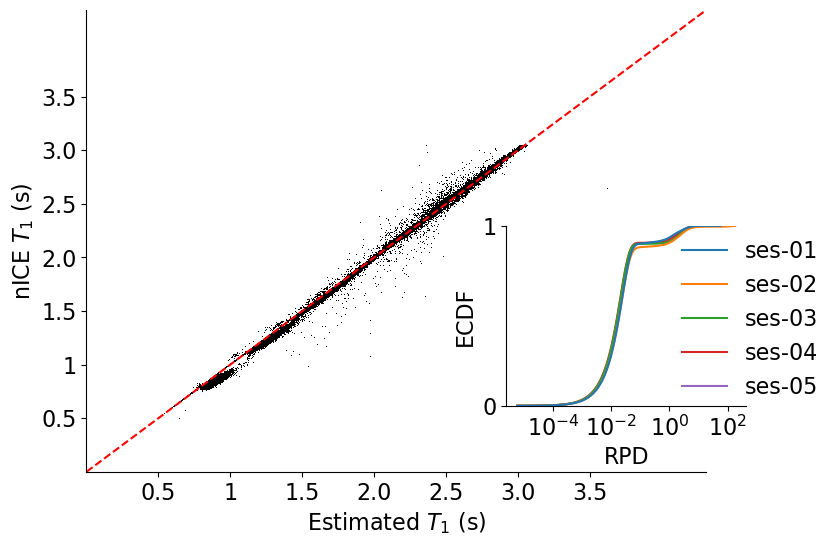

In [8]:

T1_i, nice_i, mask = next(zip(custom, nICE, masks))

fig, ax1 = plt.subplots(figsize=(8, 6)) # Adjust figsize as needed

# Plot the main scatter plot
ax1.plot(T1_i[mask], nice_i[mask], marker=",", linestyle="", color="k", alpha=1.0, rasterized=True)
ax1.plot([0, 10000], [0, 10000], ls="--", color="r")
max_val = max(np.nanquantile(T1_i, 0.99), np.nanquantile(nice_i, 0.99))
ax1.set_xlim(0, 1.2 * max_val)
ax1.set_ylim(0, 1.2 * max_val)   
ax1.set_xlabel('Estimated $T_1$ (s)')
ax1.set_ylabel('nICE $T_1$ (s)')

ax1.set_yticks([1000*xi for xi in ticks_seconds], ticks_seconds)
ax1.set_xticks([1000*xi for xi in ticks_seconds], ticks_seconds)


inset_ax = fig.add_axes([0.65, 0.22, 0.3, 0.3])
sns.ecdfplot(frame, x="RPD", hue="Session", log_scale=True, ax=inset_ax)
legend = inset_ax.get_legend()
legend.set_title("")
legend.set_frame_on(False)
legend.set_loc("center left")
legend.set_bbox_to_anchor((0.65, 0.48))

inset_ax.set_yticks([0,1])
inset_ax.set_xticks([10**i for i in (-4, -2, 0, 2)])
inset_ax.set_ylabel("ECDF")
inset_ax.set_xlabel(r'RPD')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
inset_ax.spines['right'].set_visible(False)
inset_ax.spines['top'].set_visible(False)
plt.savefig("../figures/nICE-looklocker-comparison.pdf", bbox_inches="tight")
plt.show()

### Violinplot of RPD

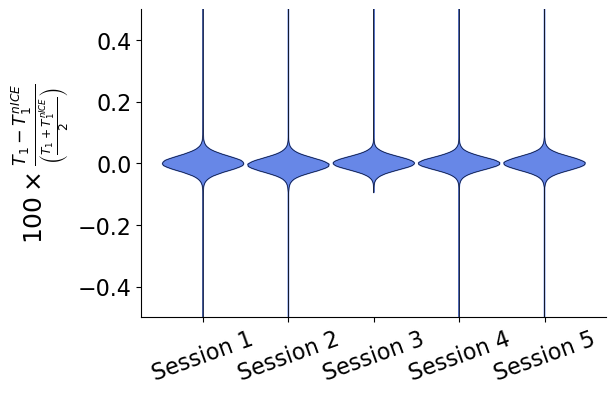

In [9]:
from sklearn.neighbors import KernelDensity
# Create the figure and axis
densities = []
for idx, ei in enumerate(errors, start=1):
    print(f"{idx}", end="\r")
    data = 100 * ei
    data_min, data_max = np.percentile(data, [0.01, 99.9])

    num_grid_points = 500  # Adjust for balance between detail and performance
    # Cubed for higher point density close to 0
    grid = np.linspace(np.cbrt(data_min), np.cbrt(data_max), num_grid_points)[:, np.newaxis]**3

    # Instantiate and fit the KernelDensity model
    bandwidth = 0.001
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data[:, np.newaxis])

    # Evaluate the density model on the grid
    log_density = kde.score_samples(grid)
    density = np.exp(log_density)

    # Normalize the density for plotting
#     density /= density.max() 
    densities.append((grid, density))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))
for idx, (grid, density) in enumerate(densities, start=1):
    # Plot the violin shape
    norm_density = density / (density.max() * 2.1)
    ax.fill_betweenx(grid.ravel(), idx-norm_density, idx+norm_density, color="royalblue", alpha=0.8)
    ax.plot(idx - norm_density, grid.ravel(), color="k", lw=0.4)
    ax.plot(idx + norm_density, grid.ravel(), color="k", lw=0.4)

plt.ylim(-0.5, 0.5)
plt
plt.xticks(range(1, 6), [f"Session {idx}" for idx in range(1, 6)], rotation=20)
ax.set_ylabel(r'$100 \times \frac{T_1 - T_1^{nICE}}{\left(\frac{T_1 + T_1^{nICE}}{2}\right)}$', fontsize=18)
plt.savefig("../figures/LL-nICE-rpd-violin.png", bbox_inches="tight")
plt.show()

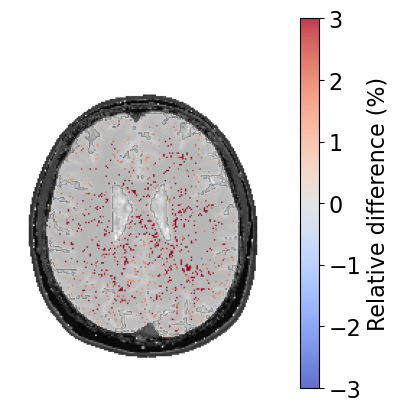

In [10]:
sagittal_slice = ("sagittal", 95)
coronal_slice = ("coronal", 150)
axial_slice = ("axial", 165)
s = axial_slice

plt.figure(frameon=False)
plt.imshow(slice_volume(custom[0], *s), vmax=4500, cmap="gray")
plt.imshow(slice_volume(e[0], *s) * 100, vmin=-3, vmax=3, alpha=0.8, cmap="coolwarm")
plt.gca().set_facecolor("black")
plt.colorbar(label="Relative difference (%)")
plt.axis("off")
plt.savefig("../figures/LL-nICE-axial-error.pdf", bbox_inches="tight")
plt.show()